# 3. Dimensionality reduction with PCA and ICA

Scattering coefficients contain high-level information in a high-dimensional space.
That is cumbersome to analyse and, therefore, we use dimensionality reduction techniques to retrieve the most relevant information, contained within a few dimensions (which we call features).
This tutorial reduces the dimensions of the scattering coefficients using a principal component analysis (PCA) and independent component analysis (ICA). 
The features can then be used for interpreting the time series or for downstream tasks such as clustering.
We have used the independent components for clustering in Steinmann et al. ([2021](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2021JB022455))
and for interpretation in Steinmann et al. [2022](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2022GL098854).
We advise that many other methods for reducing the dimensions may be relevant for other datasets. 
In the following tutorial, we will also investigate a manifold learning technique, called UMAP, for reducing the dimensions.

Made in April 2023 by René Steinmann and Léonard Seydoux.

Updated in November 2023.

> **Note**: This notebook requires the installation of the matplotlib and scikit-learn libraries, which are not included in the default installation of the scatseisnet library. To install them, please visit the [matplotlib website](https://matplotlib.org/stable/users/installing.html) and the [scikit-learn website](https://scikit-learn.org/stable/install.html).

In [1]:
import pickle

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from sklearn.decomposition import FastICA, PCA

plt.rcParams["date.converter"] = "concise"
%config InlineBackend.figure_format = "svg"

## 3.0 Load scattering coefficients

First, we load the scattering coefficients and reshape them for any [dimensionality reduction](https://scikit-learn.org/stable/modules/unsupervised_reduction.html) model (here `PCA` and `FastICA`) of the `scikit-learn` package. The shape of the scattering coefficients are given by the following tuples:

- Order 1: `(n_times, n_channel, octaves[0] * resolution[0])`
- Order 2: `(n_times, n_channel, octaves[0] * octaves[1] * resolution[0]  *
  resolution[1])`
- ...
- Order n: `(n_times, n_channel, np.prod(octaves) * np.prod(resolution))`

We then need to collect the all-order scattering coefficients into a
two-dimensional matrix for the `PCA/FastICA` application. 

> Note that the optimal way to load the scattering coefficients is to use `xarray` 

In [2]:
# Load data from file
with np.load("../example/scattering_coefficients.npz", allow_pickle=True) as data:
    order_1 = data["order_1"]
    order_2 = data["order_2"]
    times = data["times"]

# Reshape and stack scattering coefficients of all orders
order_1 = order_1.reshape(order_1.shape[0], -1)
order_2 = order_2.reshape(order_2.shape[0], -1)
scattering_coefficients = np.hstack((order_1, order_2))

# transform into log
scattering_coefficients = np.log10(scattering_coefficients)

# print info about shape
n_times, n_coeff = scattering_coefficients.shape
print("Collected {} samples of {} dimensions each.".format(n_times, n_coeff))

Collected 4319 samples of 504 dimensions each.


## 3.1 Feature extraction

After loading and reorganizing the scattering coefficients into a matrix, we can now apply a dimentionality reduction algorithm. We will use the `PCA` and `FastICA` algorithm, but highly recommend to try other algorithms that will allow to proceed in the most adapted way to the data at hand. Both algorithms are considered a linear dimensionality reduction method.

### 3.1.0 Principal component analysis PCA

`PCA` from `sklearn` uses the singular value decomposition to reduce the dimension of any data matrix, which is centered beforehand. The `n_components` keyword argument informs the model about how many components (or features) we want to extract. The residual shape of the `features` matrix will be `(n_times, n_components)` instead of the initial scattering coefficients shape shown above.

In [3]:
pca_model = PCA(n_components=10, whiten=True)
pca_features = pca_model.fit_transform(scattering_coefficients)

#### Have a look at the features

This is a crucial step: do you see structure in the features, or do they seem all random? Do the structures correlate with the a priori information at your disposal or to identifiable signal structures? At this stage, it is important to carefully address those questions. The optimal solution may not be to use the `PCA` model depending on the data at hand, although it can be adapated to many datasets. Playing with the number of components can also be an important way of creating structure in the output.

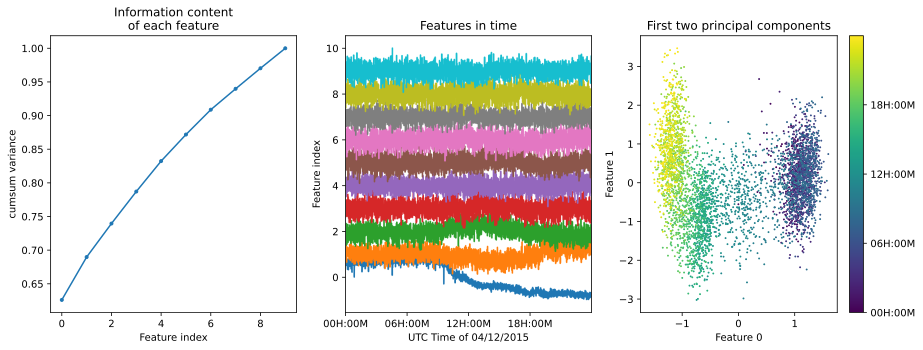

In [4]:
# Normalize features for display
features_normalized = pca_features / np.abs(pca_features).max(axis=0)
myFmt = mdates.DateFormatter('%HH:%MM')

# Figure and axes instance
fig, axes = plt.subplots(1,3,figsize=(15,5),dpi=200)

# Plot the cumulative sum of the explained variance ratio of the principal components
axes[0].plot(np.cumsum(pca_model.explained_variance_ratio_/sum(pca_model.explained_variance_ratio_)),'.-')
axes[0].set_ylabel("cumsum variance")
axes[0].set_xlabel("Feature index")
axes[0].set_title("Information content\nof each feature")

# Plot features in time
axes[1].plot(times, features_normalized + np.arange(features_normalized.shape[1]), rasterized=True)
axes[1].set_xlim(times.min(),times.max())
axes[1].xaxis.set_major_formatter(myFmt)
axes[1].xaxis.set_major_locator(mdates.HourLocator(interval=6))
axes[1].set_ylabel("Feature index")
axes[1].set_xlabel("UTC Time of 04/12/2015")
axes[1].set_title("Features in time")



# Plot the first two principal components
mappable = axes[2].scatter(pca_features[:,0],pca_features[:,1],s=1,c=mdates.date2num(times))
axes[2].set_ylabel("Feature 1")
axes[2].set_xlabel("Feature 0")
axes[2].set_title("First two principal components")

cbar_ax = plt.colorbar(mappable)
cbar_ax.ax.set_ylim(times.min(),times.max())
cbar_ax.ax.yaxis.set_major_formatter(myFmt)
cbar_ax.ax.yaxis.set_major_locator(mdates.HourLocator(interval=6))

# Show
plt.show()

#### Interpretation

Each principal component reflects a variance score from the original data, indicating how much information is preserved. In our case, the first principal component (feature 0) represents more than 60 % of the data's variance. The second component (feature 1) explains more than 5 % variance and so on. The time history of feature 0 seems to reflect the time history of the tremor signal in the seismogram. With increasing feature index, the time history appear more random, containing less important information for our task at hand. On the right handside, we show the first two features and color-code the data points with its corresponding timestamp.

### 3.1.1 Independent component analysis ICA

The PCA analysis showed us that only a few components contain relevant information and we can use that knowledge to set the number of components from 10 to a lower number for the ICA analysis. ICA whitens the data beforehand and, therefore, we can not rank or score the independent components as we did for the principal components. In the following example, we set the number of components to 4, a choice which is mainly guided visually.

The `FastICA` algorithm, included in the `sklearn` package, is one fo the most common algorithm to perform ICA. It factorizes the data matrix (in our case scattering coefficient matrix) into an independent source matrix and a mixing matrix. The `n_components` keyword argument informs the model about how many components (or features, or sources) we want to extract. The residual shape of the `features` matrix will be `(n_times, n_components)` instead of the initial scattering coefficients shape shown above.

Settung the `random_state` parameter to an integer helps to reproduce the same results, which might be important if you want to test different model parameters. More on the parameters can be found on the  [webpage](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html#sklearn.decomposition.FastICA) of sklearn.

In [5]:
ica_model = FastICA(n_components=4, whiten="unit-variance", random_state=42)
ica_features = ica_model.fit_transform(scattering_coefficients)

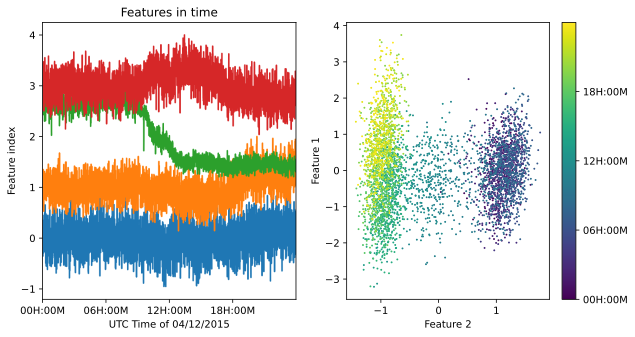

In [6]:
# Normalize features for display
features_normalized = ica_features / np.abs(ica_features).max(axis=0)
myFmt = mdates.DateFormatter('%HH:%MM')

# Figure and axes instance
fig, axes = plt.subplots(1,2,figsize=(10,5),dpi=200)

# Plot features in time
axes[0].plot(times, features_normalized + np.arange(ica_features.shape[1]), rasterized=True)
axes[0].set_xlim(times.min(),times.max())
axes[0].xaxis.set_major_formatter(myFmt)
axes[0].xaxis.set_major_locator(mdates.HourLocator(interval=6))
axes[0].set_ylabel("Feature index")
axes[0].set_xlabel("UTC Time of 04/12/2015")
axes[0].set_title("Features in time")


# Plot the first two principal components
mappable = axes[1].scatter(ica_features[:,2],ica_features[:,1],s=1,c=mdates.date2num(times))
axes[1].set_ylabel("Feature 1")
axes[1].set_xlabel("Feature 2")

cbar_ax = plt.colorbar(mappable)
cbar_ax.ax.set_ylim(times.min(),times.max())
cbar_ax.ax.yaxis.set_major_formatter(myFmt)
cbar_ax.ax.yaxis.set_major_locator(mdates.HourLocator(interval=6))

# Show
plt.show()

#### Interpretation

The 4 features from ICA look similar to the first 4 features of PCA, however, we note that the ranking is different. The ranking of ICA has no importance, i.e. ICA does not sort its components after an eigenvalue as PCA does. If we do not fix the `random_state` parameter, the ranking and sign of the components might change with each run. On the right handside, we show the two ICA features which contain similar information to the first two PCA features.


#### Save the output

We here save the extracted features from the ICA model as a npz-file for other downstream tasks, like the scattering coefficients in the previous notebook.

In [7]:
# Save the features
np.savez(
    "../example/independent_components.npz",
    features=ica_features,
    times=times,
)

# Save the dimension reduction model
with open("../example/dimension_model.pickle", "wb") as pickle_file:
    pickle.dump(
        ica_model,
        pickle_file,
        protocol=pickle.HIGHEST_PROTOCOL,
    )